# Машинное обучение модели классификации базы контрактов 
# (Machine learning model for contract base classification)

#### Описание задачи (Task description):
**Исходная информация**
Имеется база поставщиков, которая содержит информацию о заключенных контрактах. Указанная информация по контрактам содержит в себе данные о контрактах, поставщиках, покупателях, номенклатуре продукции (всего более 20 переменных). Также имется информация о наличии, либо отсутствии у поставщика специализированного программного обеспечения (ПО) для поиска покупателей.

**Описание задачи**
Задача на основании имеющейся информации о контрактах поставщика и ПО построить и обучить предиктивную модель, которая будет определять наличие/отсутствие ПО. Основная практическая цель такой модели выявление потенциальных покупателей ПО. С помощью модели прогнозируется потенциальность покупателя (наличие ПО: да/нет). Затем на основании прогноза модели определяются потенциальные покупатели - поставщики, которых модель определила как имеющих ПО (наличе ПО), но у которых оно отсутствует.

**Source information**
There is a database of suppliers that contains information about contracts. The specification of contract contains data about contracts, suppliers, customers, product range (more than 20 variables of total). There is also information about specialized software of the supplier  to search for buyers (software: yes / no).

**Task formulation**
Based on the available information about the supplier contracts and software, build and train a predictive model that will determine the presence / absence of software. The main practical goal of this model is to identify potential buyers of software. The model predicts the potentiality of the buyer (presence / absence of software). Then, based on the forecast of the model, potential buyers are determined - suppliers, whom the model identified as having software (presence of software), but who do not have it.

### 1. Подготовка и обработка датасета (Preparation and preprocessing of dataset)

#### Обработка массива данных по номенклатуре (Preprocessing the sku dataset)

In [1]:
# standart library block 
import pandas as pd
import numpy as np

In [2]:
# Чтение файла с данными по sku (Reading sku data file)
skuData = pd.read_excel("../4. Dataset_train/1_skuData(shareOKPD1).xlsx", dtype={'Id': object, 'okpd1': object})

In [3]:
skuData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467464 entries, 0 to 467463
Data columns (total 5 columns):
Id                        467464 non-null object
okpd1                     467464 non-null object
shareOKPD                 467464 non-null float64
sku_quant_per_OKPD        467464 non-null int64
skuOKPD_quant_per_OKPD    467464 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 17.8+ MB


In [4]:
# Группировка данных по id и транспонирование их по ОКПД (Grouping data by id and transposing them by OKPD)
Dataset_sku = pd.pivot_table(skuData,
                             index=["Id"],
                             columns=["okpd1"], 
                             values=["shareOKPD", "skuOKPD_quant_per_OKPD"], 
                             fill_value=0)

In [5]:
# Сброс индексов и переименование столбцов (Reset index and rename columns)
Dataset_sku.reset_index()
headers = list(range(len(Dataset_sku.columns)))
Dataset_sku.columns = headers

In [6]:
# Размер датасета (Dataset size)
Dataset_sku.shape

(249061, 178)

#### Обработка массива данных по контрактам (Preprocessing the contracts dataset)

In [7]:
# Чтение файлов с данными по агрегированным переменным контактов и значению таргета (Reading contracts data file)
Dataset_contracts = pd.read_excel("../4. Dataset_train/2_CoutSumData.xlsx", dtype={'Id': object})

In [8]:
Dataset_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216846 entries, 0 to 216845
Data columns (total 17 columns):
Id                        216846 non-null object
contract_quant            216846 non-null int64
cnt_uniq_buyer            216846 non-null int64
cnt_contract_per_buyer    216846 non-null int64
cnt_buyRegion             216846 non-null int64
cnt_buy_contPerson        216846 non-null int64
personal                  216846 non-null int64
koef_act                  216846 non-null float64
tot_contractSum           216846 non-null float64
avg_contractSum           216846 non-null float64
sku_quant                 216846 non-null int64
skuOKPD_quant             216846 non-null int64
cnt_OKEI                  216846 non-null int64
org_live                  216846 non-null int64
bidding_type              216846 non-null int64
soft_target               216846 non-null int64
cnt_manager_company       216846 non-null int64
dtypes: float64(3), int64(13), object(1)
memory usage: 28.1+ MB


In [9]:
Dataset_contracts = Dataset_contracts.drop(['sku_quant'], axis=1) 

In [10]:
# Размер датасета (Dataset size)
Dataset_contracts.shape

(216846, 16)

#### Создание общего массива данных для обучения модели классификации по контрактам (Create common dataset for machine learning model)

In [11]:
# Создание общего датасета для обучения модели (Create a common dataset for machine learning)
kz_data = pd.merge(Dataset_contracts, 
                   Dataset_sku, 
                   on = 'Id')

In [12]:
# Размер итогового датасета (Total dataset size)
kz_data.shape

(216831, 194)

### 2. Построение и обучение моделей (Model building and learning)

In [13]:
# standart library block
import numpy as np
import pandas as pd
import io
import os
import requests
import seaborn as sns
import statistics
import pickle
from scipy import stats as sts
from scipy.stats import t
from scipy.stats import norm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%matplotlib inline

# learning library block
import statsmodels.formula.api as sm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, r2_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.externals import joblib

from catboost import CatBoostClassifier
from catboost import cv
from catboost.datasets import amazon
from catboost.datasets import epsilon

C:\Users\Olegin\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


#### Обучение модели (Machine learning of model)
**Разбиение датасета на train/test (Split dataset)**

In [14]:
# Определение target, feature. Распределение данных на тренировочную и тестовую выборки. 
# (Purpose of "target", "feature". Distribution of data on training and test samples.)
y=kz_data['soft_target'].copy()
X=kz_data.drop('soft_target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# Стандартизация значений переменных (Standardization of features values)
scaler = StandardScaler()
scaler.fit_transform(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

#### Модель RandomForest (Model RandomForest)

In [16]:
kz_clf = RandomForestClassifier() # выбираем тип модели (choose the type of model)
kz_clf.fit(X_train, y_train) # обучаем модель (learning of model)

kz_pred_clf_train = kz_clf.predict_proba(X_train)[:,1] # предсказание для train (prediction for train sample)
kz_pred_clf_test = kz_clf.predict_proba(X_test)[:,1] # предсказание для test (prediction for test sample)

kz_roc_auc_train_1 = np.round(roc_auc_score(y_train, kz_pred_clf_train), 2) # roc_auc for train
kz_roc_auc_test_1 = np.round(roc_auc_score(y_test, kz_pred_clf_test), 2) # roc_auc for test

print("Train: ", kz_roc_auc_train_1)
print("Test: ", kz_roc_auc_test_1)

C:\Users\Olegin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train:  1.0
Test:  0.6


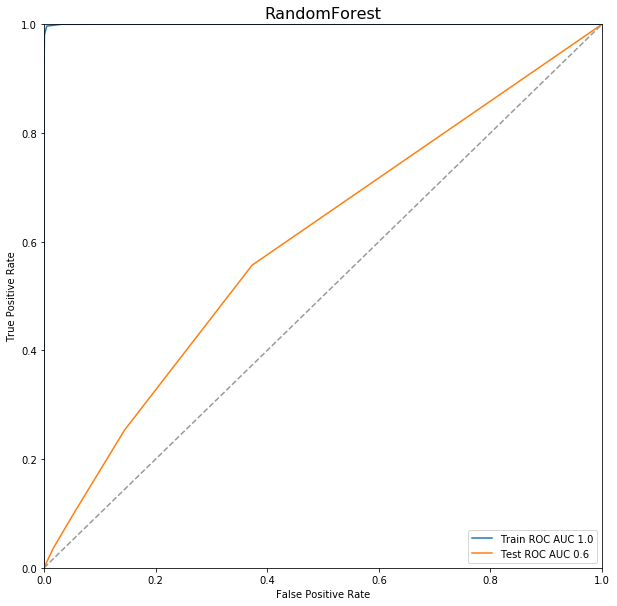

In [17]:
# Визуализация результатов обучения модели RandomForest
# (Results visualization learning of  model RandomForest)
import matplotlib

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, kz_pred_clf_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, kz_pred_clf_test)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(kz_roc_auc_train_1))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(kz_roc_auc_test_1))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest', size=16)
plt.legend(loc='lower right')
plt.show()

#### Оценка качества модели классификации RandomForest с использованием метрик: Accuracy, F1-Score, Precision, Recall (Quality assessment of the learning outcomes of the model RandomForest , with metrics: Accuracy, F1-Score, Precision, Recall)

In [18]:
# Модель RandomForest (Model RandomForest)
accuracy_clf = accuracy_score(y_test, kz_pred_clf_test.round())
f1_score_clf = f1_score(y_test, kz_pred_clf_test.round())
precision_score_clf = precision_score(y_test, kz_pred_clf_test.round())
recall_score_clf = recall_score(y_test, kz_pred_clf_test.round())

print(f'Accuracy: {accuracy_clf:.2f}')
print(f'F1_score: {f1_score_clf:.2f}')
print(f'Precision_score: {precision_score_clf:.2f}')
print(f'Recall_score: {recall_score_clf:.2f}')

Accuracy: 0.94
F1_score: 0.01
Precision_score: 0.11
Recall_score: 0.00


#### Модель GradientBoostingClassifier (Model GradientBoostingClassifier)

In [19]:
kz_gbclf = GradientBoostingClassifier() # выбираем тип модели (choose the type of model)
kz_gbclf.fit(X_train, y_train) # обучаем модель (learning of model)

kz_pred_gbclf_train = kz_gbclf.predict_proba(X_train)[:,1] # предсказание для train (prediction for train sample)
kz_pred_gbclf_test = kz_gbclf.predict_proba(X_test)[:,1] # предсказание для test (prediction for test sample)

kz_roc_auc_train = np.round(roc_auc_score(y_train, kz_pred_gbclf_train), 2) # roc_auc for train
kz_roc_auc_test = np.round(roc_auc_score(y_test, kz_pred_gbclf_test), 2) # roc_auc for test

print("Train: ", kz_roc_auc_train)
print("Test: ", kz_roc_auc_test)

Train:  0.74
Test:  0.72


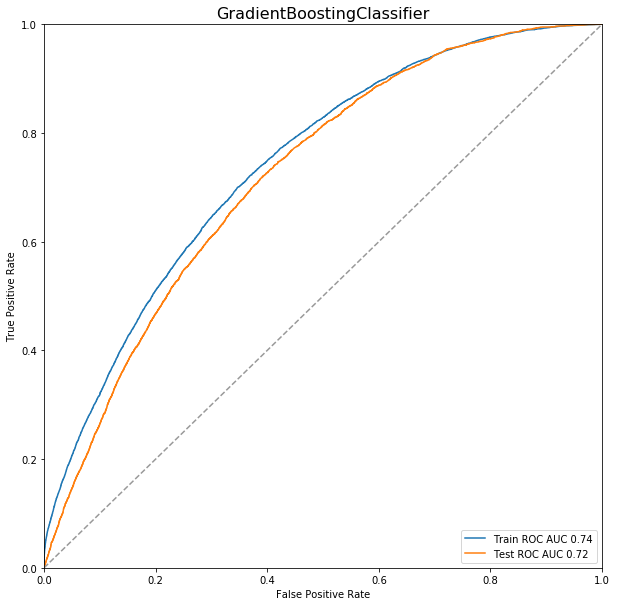

In [20]:
# Визуализация результатов обучения модели GradientBoostingClassifier
# (Results visualization learning of  model GradientBoostingClassifier)
import matplotlib

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, kz_pred_gbclf_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, kz_pred_gbclf_test)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(kz_roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(kz_roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GradientBoostingClassifier', size=16)
plt.legend(loc='lower right')
plt.show()

#### Оценка качества модели классификации GradientBoostingClassifier с использованием метрик: Accuracy, F1-Score, Precision, Recall (Quality assessment of the learning outcomes of the model GradientBoostingClassifier , with metrics: Accuracy, F1-Score, Precision, Recall)

In [21]:
# Модель GradientBoostingClassifier (Model GradientBoostingClassifier)
accuracy_gbclf = accuracy_score(y_test, kz_pred_gbclf_test.round())
f1_score_gbclf = f1_score(y_test, kz_pred_gbclf_test.round())
precision_score_gbclf = precision_score(y_test, kz_pred_gbclf_test.round())
recall_score_gbclf = recall_score(y_test, kz_pred_gbclf_test.round())

print(f'Accuracy: {accuracy_gbclf:.2f}')
print(f'F1_score: {f1_score_gbclf:.2f}')
print(f'Precision_score: {precision_score_gbclf:.2f}')
print(f'Recall_score: {recall_score_gbclf:.2f}')

Accuracy: 0.94
F1_score: 0.00
Precision_score: 0.20
Recall_score: 0.00


#### Модель CatBoost

In [23]:
kz_cat = CatBoostClassifier() # выбираем тип модели (choose the type of model)
kz_cat.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True) # обучаем модель (learning of model)

kz_pred_cat_train = kz_cat.predict_proba(data=X_train)[:,1] # предсказание для train (prediction for train sample)
kz_pred_cat_test = kz_cat.predict_proba(data=X_test)[:,1] # предсказание для test (prediction for test sample)

kz_roc_auc_train_2 = np.round(roc_auc_score(y_train, kz_pred_cat_train), 2) # roc_auc for train
kz_roc_auc_test_2 = np.round(roc_auc_score(y_test, kz_pred_cat_test), 2) # roc_auc for test

print("Train: ", kz_roc_auc_train_2)
print("Test: ", kz_roc_auc_test_2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train:  0.79
Test:  0.73


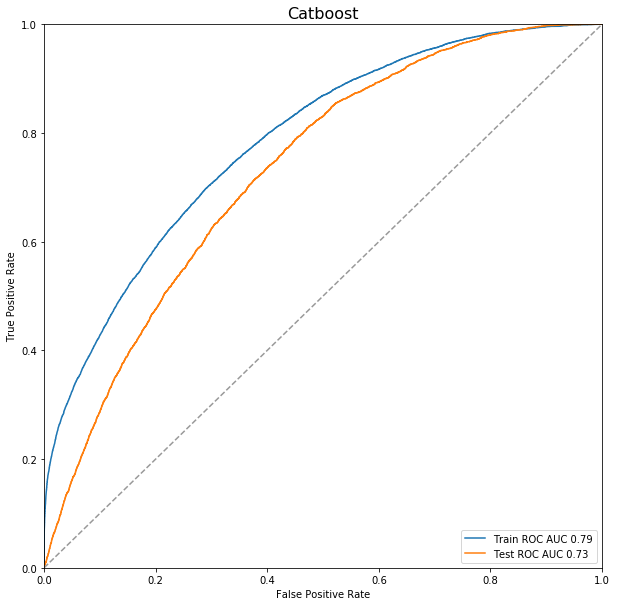

In [24]:
# Визуализация результатов обучения модели CatBoost
# (Results visualization learning of  model CatBoost)
import matplotlib

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, kz_pred_cat_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, kz_pred_cat_test)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(kz_roc_auc_train_2))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(kz_roc_auc_test_2))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Catboost', size=16)
plt.legend(loc='lower right')
plt.show()

#### Оценка качества модели классификации CatBoost с использованием метрик: Accuracy, F1-Score, Precision, Recall (Quality assessment of the learning outcomes of the model CatBoost, with metrics: Accuracy, F1-Score, Precision, Recall)

In [25]:
# Модель CatBoost (Model CatBoost)
accuracy_clf = accuracy_score(y_test, kz_pred_cat_test.round())
f1_score_clf = f1_score(y_test, kz_pred_cat_test.round())
precision_score_clf = precision_score(y_test, kz_pred_cat_test.round())
recall_score_clf = recall_score(y_test, kz_pred_cat_test.round())

print(f'Accuracy: {accuracy_clf:.2f}')
print(f'F1_score: {f1_score_clf:.2f}')
print(f'Precision_score: {precision_score_clf:.2f}')
print(f'Recall_score: {recall_score_clf:.2f}')

Accuracy: 0.94
F1_score: 0.00
Precision_score: 0.15
Recall_score: 0.00


#### Модель CatBoost с использованием кросс-валидации

In [26]:
from catboost import Pool, cv

In [27]:
# Определение тренировочного пула даных
train_pool = Pool(data=X, label=y, has_header=True)

In [28]:
# Параметры кросс-валидации
params = {
    'loss_function': 'Logloss',
    'iterations': 1000,
    'custom_loss': 'AUC',
    "verbose": False,
}

In [29]:
# Обучение модели на кросс-валидации
cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [30]:
# Функция выводящая лучший результат LogLoss на тесте
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-Logloss-std'][best_iter],
        best_iter)
    )

In [ ]:
# Функция выводящая лучший результат AUC на тесте
def print_cv_AUC(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-AUC-mean'].max()
    best_iter = cv_data['test-AUC-mean'].values.argmax()

    print('Best validation AUC score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-AUC-std'][best_iter],
        best_iter)
    )

In [41]:
# Результаты теста на кросс-валидации
print_cv_summary(cv_data)
print_cv_AUC(cv_data)

Best validation Logloss score : 0.2046±0.0006 on step 999
Best validation AUC score : 0.7346±0.0035 on step 999


In [26]:
# Сохранить результаты по модели CatBoost (Save the results by model CatBoost)
kz_cat.save_model("../2. Trained models/kz_cat_new1.json",
           format="json")
kz_cat.save_model("../2. Trained models/kz_cat_new1.cbm",
           format="cbm")

In [27]:
# Сохранить результаты по модели GradientBoostingClassifier (Save the results by model GradientBoostingClassifier)
joblib.dump(kz_gbclf, "../2. Trained models/kz_gbclf_new1.pkl")